In [1]:
%matplotlib inline
from __future__ import division
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import struct
import pickle
import pandas as pd
import random

In [3]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.datasets import imdb
from keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D

Using TensorFlow backend.


In [4]:
import sys
sys.path.append('../../src')

In [5]:
from pylab import rcParams
from IPython.display import clear_output
rcParams['figure.figsize'] = 16, 8
pd.options.display.max_columns = 999

In [18]:
from utils import FloatConvert32, FloatConvert64
from microssembly2 import Microssembly
from price_generator import random_walk, random_price
from simple_strategy import plot_trades
from test_loss import test_loss_function

In [7]:
def get_strategy_signal(price, short_ma, long_ma, demo=False):
    short_ma = abs(int(short_ma))
    long_ma = abs(int(long_ma))
    shares = 1

    try:
        ms = price.rolling(short_ma).mean()
        ml = price.rolling(long_ma).mean()

        buy = (ms > ml) & (ms.shift() < ml.shift())  # ma cross up
        sell = (ms < ml) & (ms.shift() > ml.shift())  # ma cross down
        signal = pd.Series(index=price.index)
        signal[buy[buy != False].index] = shares
        signal[sell[sell != False].index] = 0
    except Exception as e:
        print('Long {} Short {}'.format(long_ma, short_ma))
        raise e

    if demo is True:
        ax = price.plot()
        ms.plot()
        ml.plot()
        plt.legend(['price', 'Short MA', 'Long MA'], loc='best')
        ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)

    return signal

In [8]:
def plot_signals(observed_signal, signal):
    df = pd.DataFrame({'true': observed_signal - 0.5, 'generated': signal - 0.5}, index=observed_signal.index)
    ax = df.plot.bar()
    my_xticks = ['Sell', 'Buy']
    ax.set_yticks([-1, 1])
    ax.set_yticklabels(my_xticks)
    ax.set_xticklabels([])

In [9]:
def pad_left(series, n):
        head = series.index[0]
        pad_value = series[0]
        pad = pd.Series(np.full(n, pad_value), index=pd.date_range(start = head - pd.DateOffset(days=n-1),
                                                                   end = head) - pd.DateOffset(days=1))
        return pad.append(series)

In [10]:
def price_2_seq(price):
    p = (price - price.shift(1)).fillna(0)
    p = pad_left(p, 8 - 1)
    return np.array([p.shift(-x).values[:8] for x in range(len(p) - 7)[::]])

In [11]:
price = random_price(365 * 10)
signal = get_strategy_signal(price, 2, 5, False)
price.shape, signal.dropna().shape

((3651,), (861,))

In [12]:
Y = to_categorical(signal.fillna(2).values)
x_train = price_2_seq(price)[:2000]
y_train = Y[:2000]
x_test = price_2_seq(price)[2000:]
y_test = Y[2000:]

In [13]:
model = Sequential()
model.add(LSTM(128, input_shape=(8, 1)))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [14]:
model.fit(np.expand_dims(x_train, axis=2), y_train,
          batch_size=32,
          epochs=15,
          validation_data=(np.expand_dims(x_test, axis=2), y_test))

Train on 2000 samples, validate on 1651 samples
Epoch 1/15
2000/2000 [==============================] - 2s 818us/step - loss: 0.7970 - val_loss: 0.6739
Epoch 2/15
2000/2000 [==============================] - 1s 397us/step - loss: 0.7056 - val_loss: 0.6419
Epoch 3/15
2000/2000 [==============================] - 1s 391us/step - loss: 0.6476 - val_loss: 0.5644
Epoch 4/15
2000/2000 [==============================] - 1s 392us/step - loss: 0.5584 - val_loss: 0.4807
Epoch 5/15
2000/2000 [==============================] - 1s 398us/step - loss: 0.4640 - val_loss: 0.4057
Epoch 6/15
2000/2000 [==============================] - 1s 398us/step - loss: 0.3797 - val_loss: 0.3501
Epoch 7/15
2000/2000 [==============================] - 1s 391us/step - loss: 0.3327 - val_loss: 0.2923
Epoch 8/15
2000/2000 [==============================] - 1s 392us/step - loss: 0.2823 - val_loss: 0.2537
Epoch 9/15
2000/2000 [==============================] - 1s 390us/step - loss: 0.2564 - val_loss: 0.2246
Epoch 10/15
2000

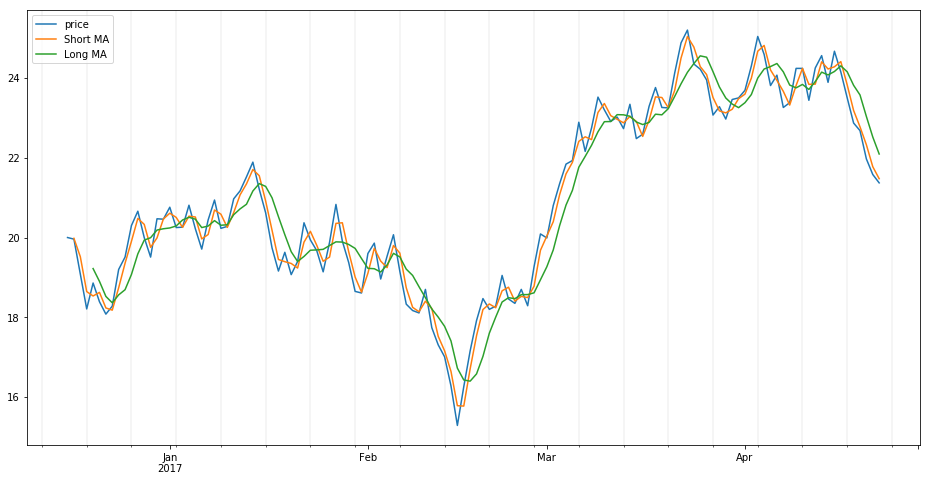

In [15]:
price = random_price()
signal = get_strategy_signal(price, 2, 5, True)

In [16]:
f = np.expand_dims(price_2_seq(price), axis=2)
predicted_signal = pd.Series(np.argmax(model.predict(f), axis=1), index=price.index).replace(2, np.nan)

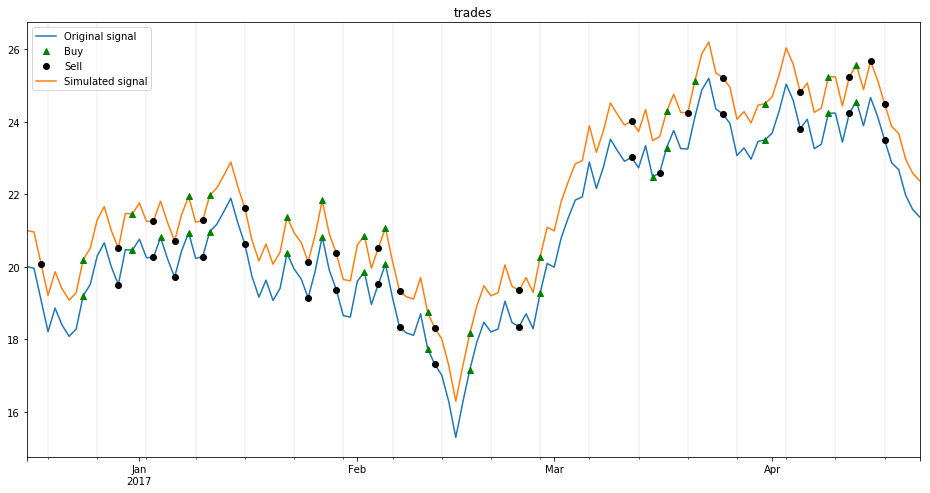

In [17]:
plot_trades(price, signal, plt)
plot_trades(price + 1, predicted_signal, plt)
plt.legend(['Original signal', 'Buy', 'Sell', 'Simulated signal'], loc='best')

In [21]:
all_loss = []
for i in range(100):
    price = random_price()
    f = np.expand_dims(price_2_seq(price), axis=2)
    signal = pd.Series(np.argmax(model.predict(f), axis=1), index=price.index).replace(2, np.nan)
    observed_signal = get_strategy_signal(price, 2, 5, False)
    all_loss.append(test_loss_function(signal.fillna(2, inplace=False), observed_signal.fillna(2, inplace=False)))
np.average(all_loss)

0.8791125949295301